### **rnnを実装してみる**

## **必要な関数・ライブラリ等の準備**

In [122]:
# データ加工・処理・分析モジュール
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

%matplotlib inline

import time

In [56]:
def set_time(dataframe, col_name):
    '''
    to_datetimeを使うための前処理
    '''
    dataframe[col_name] = dataframe[col_name].map(lambda x : transform_time(x))
    return dataframe

In [57]:
def transform_time(x):
    '''
    set_time内で使う関数
    to_datetimeで24時をサポートしないので00に変更する処理
    '''
    str_x = str(x)
    res = ''
    if str(x)[8:10] == '24':
        res = str_x[0:4] + '-' + str_x[4:6] + '-' + str_x[6:8] + ' 00:'+str_x[10:12] 
    else:
        res = str_x[0:4] + '-' + str_x[4:6] + '-' + str_x[6:8] + ' '+ str_x[8:10] +':'+str_x[10:12]
    return res

## **データの準備**

In [99]:
# データの読み込み
# 処理済みデータを読み込む。無かったら作る
try:
    output_data = pd.read_csv('data/processed_data/out_put.tsv', delimiter = '\t')
    output_data['datetime'] = output_data['datetime'].map(lambda x : pd.to_datetime(x))
    
except:
    # train_kwhをエクセル等で開くとdatetimeが指数表示に直される可能性がある
    # その場合うまくいかないので201201010120の形になってることを確認する必要あり
    output_data = pd.read_csv('data/raw_data/train_kwh.tsv', delimiter = '\t')

    # datetimeの行をpd.Timestampのインスタンスに変更
    output_data = set_time(output_data, 'datetime')
    output_data['datetime'] = output_data['datetime'].map(lambda x : pd.to_datetime(x))

    # 30分ごとに合計を集計
    output_data = output_data.set_index('datetime').groupby(pd.TimeGrouper(freq='1800s', closed='left')).sum()

    output_data.to_csv('data/processed_data/out_put.tsv', sep='\t') 
    
output_data.head()

,datetime,SOLA01,SOLA02,SOLA03
0,2012-01-01 00:00:00,0,0.0,NaN
1,2012-01-01 00:30:00,0,0.0,NaN
2,2012-01-01 01:00:00,0,0.0,NaN
3,2012-01-01 01:30:00,0,0.0,NaN
4,2012-01-01 02:00:00,0,0.0,NaN


In [126]:
# データの読み込み
# 処理済みデータを読み込む。無かったら作る
try:
    amd_data = pd.read_csv('data/processed_data/amd_data.tsv', delimiter='\t')
    amd_data['datetime'] = amd_data['datetime'].map(lambda x : pd.to_datetime(x))
    
except:
    # 河口湖アメダスのデータを使って予測する, amd_49251
    # 各amdidはamd_masterに記載されている
    amd_data = pd.read_csv('data/raw_data/amd_49251.tsv', delimiter = '\t')

    amd_data = set_time(amd_data, 'datetime')
    amd_data['datetime'] = amd_data['datetime'].map(lambda x : pd.to_datetime(x))

    # 30分ごとに平均を集計
    amd_data = amd_data.set_index('datetime').groupby(pd.TimeGrouper(freq='1800s', closed='left')).mean()

    amd_data.to_csv('data/processed_data/amd_data.tsv', sep='\t')

amd_data.head()

,pr,f_pr,max_ws,f_max_ws,ave_wv,f_ave_wv,ave_ws,f_ave_ws,max_tp,f_max_tp,min_tp,f_min_tp,sl,f_sl,sd,f_sd,dsd,f_dsd
datetime,,,,,,,,,,,,,,,,,,
2012-01-01 00:00:00,0.0,0.0,22.333333,0.0,20.333333,0.0,10.000000,0.0,-15.666667,0.0,-26.333333,0.0,0.0,2.0,0.0,0.0,0.0,0.0
2012-01-01 00:30:00,0.0,0.0,15.333333,0.0,25.000000,0.0,9.333333,0.0,-34.666667,0.0,-40.000000,0.0,0.0,2.0,0.0,0.0,0.0,0.0
2012-01-01 01:00:00,0.0,0.0,20.000000,0.0,25.000000,0.0,10.666667,0.0,-35.333333,0.0,-43.666667,0.0,0.0,2.0,0.0,0.0,0.0,0.0
2012-01-01 01:30:00,0.0,0.0,20.333333,0.0,21.666667,0.0,11.333333,0.0,-36.666667,0.0,-42.333333,0.0,0.0,2.0,0.0,0.0,0.0,0.0
2012-01-01 02:00:00,0.0,0.0,25.333333,0.0,21.000000,0.0,13.333333,0.0,-40.666667,0.0,-48.000000,0.0,0.0,2.0,0.0,0.0,0.0,0.0


## **モデルの構築**

前日の20時までの河口個のアメダスデータを用いて翌日の00:00~23:30を予測する
(例)

8/17の00:00 ~ 23:30を予測するとき

8/17の23:30を8/15 20:00 ~ 8/16 20:00

8/17の23:00を8/15 19:30 ~ 8/16 19:30

....

8/17の00:00を8/14 20:30 ~ 8/15 20:30で予測する

参考サイト：http://www.madopro.net/entry/char_level_lm_with_simple_rnn

In [76]:
class simpleRNN:
    def __init__(self):
        self.input_layer_size = 1
        self.hidden_layer_size = 10
        self.output_layer_size = 1
        self.batch_size = 128
        self.chunk_size = 5
        self.learning_rate = 0.001
        self.epochs = 1000
        
    def inference(self, input_data, initial_state):
        """
        input_data: (batch_size, chunk_size, input_layer_size = vocabulary_size) 次元のテンソル
        initial_state: (batch_size, hidden_layer_size) 次元の行列
        """
        
        # 重みとバイアスの初期化
        hidden_w = tf.Variable(tf.truncated_normal([self.input_layer_size, self.hidden_layer_size], stddev=0.01))
        hidden_b = tf.Variable(tf.ones([self.hidden_layer_size]))
        output_w = tf.Variable(tf.truncated_normal([self.hidden_layer_size, self.output_layer_size], srddev=0.01))
        output_b = tf.Variable(tf.ones([self.output_layer_size]))
        
        # BasicRNNCellを定義
        cell = tf.nn.rnn_cell.BasicRNNCell(self.hidden_layer_size)
        outputs, states = tf.nn.rnn(cell, input_data, initial_state=initial_state)
        
    def loss(self, output, actual_value):
        cost = tf.reduce_mean(tf.abs(output - actual_value))
        return cost
    
    def training(self, cost):
        optimizer = tf.train.AdamOptimizer(learning_rate=self.learning_rate).minimize(cost)
        return optimizer
    
    def train(self):
        # 変数の用意
        input_data = tf.placeholder('float', [None, self.chunk_size, self.input_layer_size])
        actual_value = tf.placeholder('float', [None, self.output_layer_size])
        initial_state = tf.placeholder('float', [None, self.hidden_layer_size])
        
        prediction = self.inference(input_data, initial_state)
        cost = self.loss(prediction, actual_value)
        optimizer = self.training(cost)
    
        # TensorBoardで可視化する
        tf.summary.scalar("AME", cost)
        summary = tf.summary.merge_all()
    
        # 訓練データとテストデータを用意する
        trX = 
        
        
        # ログを保存するためのディレクトリ
        timestamp = time.time()
        dirname = datetime.datetime.fromtimestamp(timestamp).strftime("%Y%m%d%H%M%S")


In [74]:
x = tf.placeholder(tf.float32)
y = tf.placeholder(tf.float32)

loss = tf.reduce_mean(tf.abs(x - y))

with tf.Session() as sess:
    print(sess.run(loss, feed_dict = {x: [1, 2, 3], y : [3, 3, 3]}))

1.0


In [108]:
output = list(output_data['SOLA01'])

In [115]:
amd_data['sl']

datetime
2012-01-01 00:00:00      0.000000
2012-01-01 00:30:00      0.000000
2012-01-01 01:00:00      0.000000
2012-01-01 01:30:00      0.000000
2012-01-01 02:00:00      0.000000
2012-01-01 02:30:00      0.000000
2012-01-01 03:00:00      0.000000
2012-01-01 03:30:00      0.000000
2012-01-01 04:00:00      0.000000
2012-01-01 04:30:00      0.000000
2012-01-01 05:00:00      0.000000
2012-01-01 05:30:00      0.000000
2012-01-01 06:00:00      0.000000
2012-01-01 06:30:00      0.000000
2012-01-01 07:00:00      0.000000
2012-01-01 07:30:00    166.666667
2012-01-01 08:00:00    400.000000
2012-01-01 08:30:00    413.333333
2012-01-01 09:00:00    576.666667
2012-01-01 09:30:00    600.000000
2012-01-01 10:00:00    600.000000
2012-01-01 10:30:00    600.000000
2012-01-01 11:00:00    600.000000
2012-01-01 11:30:00    600.000000
2012-01-01 12:00:00    600.000000
2012-01-01 12:30:00    483.333333
2012-01-01 13:00:00    586.666667
2012-01-01 13:30:00    483.333333
2012-01-01 14:00:00    536.666667
2012-

In [103]:
output_data[output_data['datetime'] == pd.to_datetime('2014-12-31 23:30')].index

Int64Index([52607], dtype='int64')

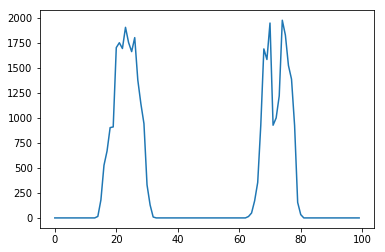

In [128]:
plt.plot(output_data['SOLA01'][0:100])

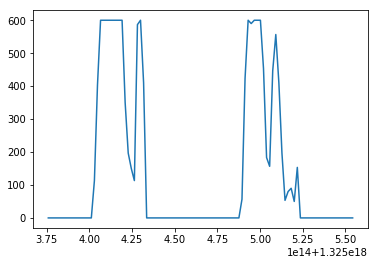

In [129]:
plt.plot(amd_data['sl'][0:100])